In [1]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 54.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 30.7 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from IPython.display import display
import base64
import string
import re
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package genesis to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/onyxia/nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/onyxia/nltk_data...


ModuleNotFoundError: No module named 'wordcloud'

# Récupération des communications

## Webscrapping

Pour voir notre travail de webscrapping, on pourra se référer au notebook nommé "Essaie webscrapp.ipynb"

## Une première base de donnée : Une centaine d'articles du NYT et du WSJ avec le mot clef environnement sur les derniers jours

## Texte fictif

Nous n'avons pas réussi à webscrapper. En attente de la base de donnée sur disque dur, nous commençons notre analyse avec une déclaration fictive :

"Green Horizons Industrial Co. Environmental Policy Statement

At Green Horizons Industrial Co., we recognize our responsibility to the environment and are committed to integrating leading environmental practices and sustainability principles into our core business strategy. We are dedicated to continuous improvement in our environmental performance, ensuring a sustainable future for generations to come.

Our environmental policy aims to minimize our carbon footprint, reduce waste, conserve natural resources, and foster innovation in eco-friendly technologies. We pledge to comply with all environmental regulations and exceed them where possible.

In our operations, we prioritize the following actions:

- Energy Efficiency: Implementing energy-saving technologies and practices to reduce our energy consumption.
- Waste Management: Reducing waste generation, promoting recycling and responsible disposal of industrial by-products.
- Water Stewardship: Conserving water resources through efficient usage and treatment systems.
- Emissions Reduction: Investing in cleaner production techniques to lower emissions and exploring renewable energy sources.
- Biodiversity Conservation: Protecting local ecosystems, supporting reforestation, and preserving natural habitats.
- Sustainable Sourcing: Partnering with suppliers who adhere to environmentally responsible practices.
- Community Engagement: Working with local communities to address environmental concerns and promote green initiatives.
- Employee Involvement: Encouraging our employees to participate in our environmental programs and make sustainable choices.

Through these commitments, we aim to lead by example in our industry and contribute positively to environmental conservation and sustainability. We believe that economic growth and environmental protection should go hand in hand, and we are dedicated to achieving this balance.

We will regularly review our environmental policy, monitor our performance, and report our progress transparently to all our stakeholders. At Green Horizons Industrial Co., we are not just compliant with today's standards—we are actively shaping a greener tomorrow."

## Base de données fictive

On va faire notre exploration à partir de la littérature anglophone (on utilise les données vu en cours avec M. Galiana) :

Edgar Allan Poe, (EAP) ;
HP Lovecraft (HPL) ;
Mary Wollstonecraft Shelley (MWS).

Nous pourrons par la suite simplement adapter notre code en ayant une base de données similaire : une colonne pour identifier l'article avec un ID, une colonne pour le texte qu'il contient, et une colonne pour le nom de l'entreprise par exemple. On pourra bien sur rajouter ensuite des colonnes qui contiendront le score de chaque article, le nom du media dans lequel il a été publié, sa date, etc.

In [3]:
url='https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'  # Pour accéder aux données fictives, utilisées en cours avec M. Galiana

df = pd.read_csv(url,
                    encoding='latin-1')
df.columns = df.columns.str.capitalize()

df['ID'] = df['Id'].str.replace("id","")
df = df.set_index('Id')

In [4]:
df.head()

,Text,Author,ID
Id,,,
id26305,"This process, however, afforded me no means of...",EAP,26305
id17569,It never once occurred to me that the fumbling...,HPL,17569
id11008,"In his left hand was a gold snuff box, from wh...",EAP,11008
id27763,How lovely is spring As we looked from Windsor...,MWS,27763
id12958,"Finding nothing else, not even gold, the Super...",HPL,12958


# Traitement

## Nettoyage

### Fonction de nettoyage d'un texte

In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocess text
def preprocess(text):
    # Tokenize text
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Test sur le texte fictif - [Validé]

In [6]:
# Read the text file
with open('/article_fictif.txt', 'r', encoding='utf-8') as file:
    text_data = file.read()

# Preprocess the text
processed_text = preprocess(text_data)

processed_text

FileNotFoundError: [Errno 2] No such file or directory: '/article_fictif.txt'

### Extension à toute une base de données

In [7]:
def preprocess_dataframe(df, group_columns, text_column):
    # Initialize Lemmatizer and Stopwords
    lemma = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Tokenization and cleaning
    df['tokenized'] = df.groupby(group_columns)[text_column].transform(lambda x: ' '.join(x))
    df['tokenized'] = df['tokenized'].apply(lambda x: word_tokenize(x))
    df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word.isalpha()])

    # Remove stopwords and apply lemmatization
    df['tokenized'] = df['tokenized'].apply(lambda x: [lemma.lemmatize(w) for w in x if not w in stop_words])

    return df.reset_index()


#### Test sur la base de données fictive [Validé]

In [8]:
df_clean = preprocess_dataframe(df, ['ID', 'Author'], 'Text')

df_clean.head(5)

,Id,Text,Author,ID,tokenized
0,id26305,"This process, however, afforded me no means of...",EAP,26305,"[This, process, however, afforded, mean, ascer..."
1,id17569,It never once occurred to me that the fumbling...,HPL,17569,"[It, never, occurred, fumbling, might, mere, m..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,11008,"[In, left, hand, gold, snuff, box, capered, hi..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,27763,"[How, lovely, spring, As, looked, Windsor, Ter..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,12958,"[Finding, nothing, else, even, gold, Superinte..."


## Regrouper les articles par sujet - LDA

In [9]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_clean['tokenized'].apply(lambda s: ' '.join(s)))

# Tweak the two parameters below
number_topics = 5
number_words = 10# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0,
                                n_jobs = 1)
lda.fit(count_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, n_jobs=1,
                          random_state=0)

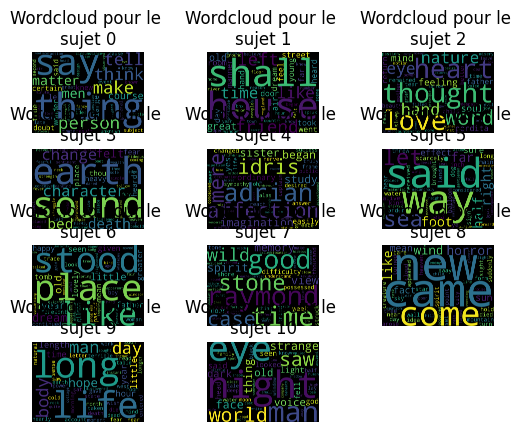

In [11]:
tf_feature_names = count_vectorizer.get_feature_names_out()

def wordcloud_lda(lda, tf_feature_names):

  fig, axs = plt.subplots(len(lda.components_) // 3 + 1, 3)
  stop_words = set(stopwords.words('english'))

  for i in range(len(lda.components_)):
      corpus_lda = lda.components_[i]
      first_topic_words = [tf_feature_names[l] for l in corpus_lda.argsort()[:-50-1:-1]]
      k = i // 3
      j = (i - k*3)
      wordcloud = WordCloud(stopwords=stop_words, background_color="black",width = 2500, height = 1800)
      wordcloud = wordcloud.generate(" ".join(first_topic_words))
      axs[k][j].set_title("Wordcloud pour le \nsujet {}".format(i))
      axs[k][j].axis('off')
      axs[k][j].imshow(wordcloud)

  r = len(lda.components_) % 3
  [fig.delaxes(axs[len(lda.components_) // 3,k-1]) for k in range(r+1, 3+1) if r != 0]

wc = wordcloud_lda(lda, tf_feature_names)
wc

## Analyse du sentiment des textes

### Sentiment général

Le score donné varie de -1 à 1 avec -1 comme la négativité maximale et 1 comme la positivité maximale. 0 pour dire que le texte est neutre.

In [13]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(token_list):
    # Join the tokens into a string for analysis
    text = ' '.join(token_list)
    return sia.polarity_scores(text)['compound']

df_clean['general_sentiment_score'] = df_clean['tokenized'].apply(get_sentiment_score)

df_clean_sorted = df_clean.sort_values(by='ID', ascending=True)
df_clean_sorted.head(10)

,Id,Text,Author,ID,tokenized,general_sentiment_score
8239,id00001,Idris was well content with this resolve of mine.,MWS,00001,"[Idris, well, content, resolve, mine]",0.5719
986,id00002,"I was faint, even fainter than the hateful mod...",HPL,00002,"[I, faint, even, fainter, hateful, modernity, ...",-0.4939
6590,id00003,"Above all, I burn to know the incidents of you...",EAP,00003,"[Above, I, burn, know, incident, passage, dark...",0.0000
13419,id00004,"He might see, perhaps, one or two points with ...",EAP,00004,"[He, might, see, perhaps, one, two, point, unu...",-0.2960
6736,id00005,All obeyed the Lord Protector of dying England...,MWS,00005,"[All, obeyed, Lord, Protector, dying, England,...",0.0000
5192,id00006,"It was difficult, at any given time, to say wi...",EAP,00006,"[It, difficult, given, time, say, certainty, u...",-0.1280
4396,id00007,"Now, it cannot be maintained, even, that by th...",EAP,00007,"[Now, maintained, even, crawling, system, grea...",0.6124
12072,id00009,Alien it indeed was to all art and literature ...,HPL,00009,"[Alien, indeed, art, literature, sane, balance...",-0.8658
17252,id00010,"""But it is true that I am a wretch.",MWS,00010,"[But, true, I, wretch]",0.5719
13791,id00012,They had deposited me in the coffin.,EAP,00012,"[They, deposited, coffin]",0.0000


### Sentiment environnemental

#### Dictionnaire

L'idéal serait de récupérer un dictionnaire pré existant, spécialisé dans l'évaluation de termes écologique, qui attribue une score à chaque terme. La difficulté à trouver ce type de dictionnaire nous mène dans un premier temps à creuser d'autres pistes de substitution. Nous verrons plus tard si nous réussissons à trouver un dictionnaire préexistant

#### Alternative aux dictionnaires pré-existants

Problème pour l'amélioration du dictionnaire : on ne trouve pas de dictionnaire préexistant avec comme spécialité l'environnement. Deux options : 

 - Améliorer notre dictionnaire fait main:
   - Avantage : On peut contrôler le poid associé à chaque mot, dans la note
   - Inconvéniant : COnstruction peu rigoureuse, on peut avoir oublié des mots
  
 - Utiliser un dictionnaire généraliste :
   - Avantage : Construction plus rigoureuse, moins de chance d'oublier certains termes
   - Inconvénient : Pas de contrôle sur le poid des mots

##### Le dictionnaire fait main

Pour le moment, on ne trouve pas de dictionnaire pré-existant, dont chaque terme peut être associé à une note environnementale. On propose donc de construire nous même un dictionnaire, un en français et l'autre en anglais.

In [14]:
# Créer un dictionnaire de termes environnementaux positifs
Dico_env_fr = {
    "propre": 1,
    "écologique": 1,
    "durable": 1,
    "vert": 1,
    "économie d'énergie": 1,
    "renouvelable": 1,
    "responsable": 1,
    "conservation": 1,
    "biodiversité": 1,
    "sain": 1,
    "bio": 1,
    "éco-friendly": 1,
    "respectueux de l'environnement": 1,
    "efficace": 1,
    "innovant": 1,
    "éthique": 1,
    "équitable": 1,
    "efficience": 1,
    "responsabilité sociale": 1,
    "sustainable": 1,
    "solidaire": 1,
    "propagation consciente": 1,
    "soutenable": 1,
    "énergie propre": 1,
    "énergie renouvelable": 1,
    "recyclage": 1,
    "efficacité énergétique": 1,
    "économie circulaire": 1,
    "énergie solaire": 1,
    "énergie éolienne": 1,
    "régénération": 1,
    "préservation": 1,
    "restauration": 1,
    "réhabilitation": 1,
    "récupération": 1,
    "restaurateur": 1,
    "régénérateur": 1,
    "revitalisation": 1,
    "positif": 1,
    "bénéfique": 1,
    "valorisation": 1,
    "épanouissement": 1,
    "amélioration continue": 1,
    "prospérité": 1,
    "harmonie": 1,
    "intégrité": 1,
    "consommation responsable": 1,
    "éco-responsable": 1,
    "éco-conscient": 1,
    "durabilité": 1,
    "récupérable": 1,
    "énergie verte": 1,
    "effet de serre": 1,
    "éco-efficace": 1,
    "éco-innovation": 1,
    "bien-être": 1,
    "éco-design": 1,
    "agroécologie": 1,
    "permaculture": 1,
    "éco-citoyen": 1,
    "carbone neutre": 1,
    "zéro déchet": 1,
    "biologique": 1,
    "éco-label": 1,
    "mobilité durable": 1,
    "éco-tourisme": 1,
    "éco-habitat": 1,
    "consommation consciente": 1,

    "pollution": -1,
    "déchet": -1,
    "déforestation": -1,
    "émissions de gaz à effet de serre": -1,
    "contamination": -1,
    "destructeur": -1,
    "irresponsable": -1,
    "gaspillage": -1,
    "nuisible": -1,
    "toxique": -1,
    "détérioration": -1,
    "dégradation": -1,
    "dommageable": -1,
    "préjudiciable": -1,
    "périlleux": -1,
    "inquiétant": -1,
    "catastrophique": -1,
    "catastrophe": -1,
    "dangereux": -1,
    "menace": -1,
    "risque": -1,
    "nocif": -1,
    "néfaste": -1,
    "inadéquat": -1,
    "inapproprié": -1,
    "inopportun": -1,
    "nuire": -1,
    "endommagement": -1,
    "dommages": -1,
    "polluant": -1,
    "polluer": -1,
    "détériorer": -1,
    "perturbation": -1,
    "irrespectueux": -1,
    "malveillant": -1,
    "dégât": -1,
    "agressif": -1,
    "ravageur": -1,
    "gâcher": -1,
    "perturber": -1,
    "endommager": -1,
    "irréparable": -1,
    "toxicité": -1,
    "inacceptable": -1,
    "dommage écologique": -1,
    "abattage illégal": -1,
    "surconsommation": -1,
    "pillage des ressources": -1,
    "dégradation de l'environnement": -1,
    "espace naturel détruit": -1,
    "exploitation excessive": -1,
    "surexploitation": -1,
    "réchauffement climatique": -1,
    "déni environnemental": -1,
}
liste_negation = ["pas", "non","jamais", "aucun", "nul", "rien", "personne", "négatif", "sans", "plus", "moins"]

liste_annulation_negation = ["responsable","à l'origine","la source"]

In [13]:
Dico_env_en = {
    
    "clean": 1,
    "ecological": 1,
    "sustainable": 1,
    "green": 1,
    "energy-efficient": 1,
    "renewable": 1,
    "responsible": 1,
    "conservation": 1,
    "biodiversity": 1,
    "healthy": 1,
    "organic": 1,
    "eco-friendly": 1,
    "environmentally friendly": 1,
    "efficient": 1,
    "innovative": 1,
    "ethical": 1,
    "fair": 1,
    "efficiency": 1,
    "social responsibility": 1,
    "sustainable": 1,
    "solidarity": 1,
    "conscious spreading": 1,
    "sustainable": 1,
    "clean energy": 1,
    "renewable energy": 1,
    "recycling": 1,
    "energy efficiency": 1,
    "circular economy": 1,
    "solar energy": 1,
    "wind energy": 1,
    "regeneration": 1,
    "preservation": 1,
    "restoration": 1,
    "rehabilitation": 1,
    "recovery": 1,
    "restorer": 1,
    "regenerator": 1,
    "revitalization": 1,
    "positive": 1,
    "beneficial": 1,
    "valorization": 1,
    "fulfillment": 1,
    "continuous improvement": 1,
    "prosperity": 1,
    "harmony": 1,
    "integrity": 1,
    "responsible consumption": 1,
    "eco-responsible": 1,
    "eco-conscious": 1,
    "sustainability": 1,
    "recoverable": 1,
    "green energy": 1,
    "greenhouse effect": 1,
    "eco-efficient": 1,
    "eco-innovation": 1,
    "well-being": 1,
    "eco-design": 1,
    "agroecology": 1,
    "permaculture": 1,
    "eco-citizen": 1,
    "carbon neutral": 1,
    "zero waste": 1,
    "organic": 1,
    "eco-label": 1,
    "sustainable mobility": 1,
    "eco-tourism": 1,
    "eco-habitat": 1,
    "conscious consumption": 1,
    
    "pollution": -1,
    "waste": -1,
    "deforestation": -1,
    "greenhouse gas emissions": -1,
    "contamination": -1,
    "destructive": -1,
    "irresponsible": -1,
    "wasteful": -1,
    "harmful": -1,
    "toxic": -1,
    "deterioration": -1,
    "degradation": -1,
    "damaging": -1,
    "harmful": -1,
    "perilous": -1,
    "worrisome": -1,
    "catastrophic": -1,
    "catastrophe": -1,
    "dangerous": -1,
    "threat": -1,
    "risk": -1,
    "hazardous": -1,
    "harmful": -1,
    "inappropriate": -1,
    "inadequate": -1,
    "inappropriate": -1,
    "harm": -1,
    "damage": -1,
    "pollutant": -1,
    "pollute": -1,
    "deteriorate": -1,
    "disruption": -1,
    "disrespectful": -1,
    "malevolent": -1,
    "damage": -1,
    "aggressive": -1,
    "ravager": -1,
    "spoil": -1,
    "disturb": -1,
    "damage": -1,
    "irreparable": -1,
    "toxicity": -1,
    "unacceptable": -1,
    "ecological damage": -1,
    "illegal logging": -1,
    "overconsumption": -1,
    "resource plundering": -1,
    "environmental degradation": -1,
    "destroyed natural habitat": -1,
    "excessive exploitation": -1,
    "overexploitation": -1,
    "climate change": -1,
    "environmental denial": -1,
}

negation_list = ["not", "no", "never", "none", "nil", "nothing", "nobody", "negative", "without", "more", "less"]

negation_cancellation_list = ["responsible", "originally", "source"]

##### Dictionnaire généraliste

Afin d'explorer la puissance d'un dictionnaire pré exsitant, nous faisant le choix de considérer un dictionnaire pré-existant, même s'il n'est pas spécialisé dans l'environnement

In [9]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('sentiwordnet')

# Termes à examiner
terms = ["good", "bad", "environment", "technology","greenhouse","gases","greenhouse gas"]

for term in terms:
    # Obtenir les synsets associés au terme
    synsets = list(swn.senti_synsets(term))

    if synsets:
        print(f"Scores de sentiment pour le terme '{term}':")
        for synset in synsets:
            print(f"POS: {synset.pos_score()}, NEG: {synset.neg_score()}, OBJ: {synset.obj_score()}")
        print()
    else:
        print(f"Aucun synset trouvé pour le terme '{term}'.\n")

[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


Scores de sentiment pour le terme 'good':
POS: 0.5, NEG: 0.0, OBJ: 0.5
POS: 0.875, NEG: 0.0, OBJ: 0.125
POS: 0.625, NEG: 0.0, OBJ: 0.375
POS: 0.0, NEG: 0.0, OBJ: 1.0
POS: 0.75, NEG: 0.0, OBJ: 0.25
POS: 0.0, NEG: 0.0, OBJ: 1.0
POS: 1.0, NEG: 0.0, OBJ: 0.0
POS: 1.0, NEG: 0.0, OBJ: 0.0
POS: 0.625, NEG: 0.0, OBJ: 0.375
POS: 1.0, NEG: 0.0, OBJ: 0.0
POS: 0.75, NEG: 0.0, OBJ: 0.25
POS: 0.625, NEG: 0.0, OBJ: 0.375
POS: 0.625, NEG: 0.0, OBJ: 0.375
POS: 0.5, NEG: 0.0, OBJ: 0.5
POS: 0.5, NEG: 0.0, OBJ: 0.5
POS: 0.375, NEG: 0.0, OBJ: 0.625
POS: 0.625, NEG: 0.0, OBJ: 0.375
POS: 0.0, NEG: 0.0, OBJ: 1.0
POS: 0.625, NEG: 0.0, OBJ: 0.375
POS: 0.75, NEG: 0.0, OBJ: 0.25
POS: 0.75, NEG: 0.0, OBJ: 0.25
POS: 0.875, NEG: 0.0, OBJ: 0.125
POS: 0.5, NEG: 0.0, OBJ: 0.5
POS: 0.375, NEG: 0.125, OBJ: 0.5
POS: 0.75, NEG: 0.0, OBJ: 0.25
POS: 0.375, NEG: 0.0, OBJ: 0.625
POS: 0.0, NEG: 0.0, OBJ: 1.0

Scores de sentiment pour le terme 'bad':
POS: 0.0, NEG: 0.875, OBJ: 0.125
POS: 0.0, NEG: 0.625, OBJ: 0.375
POS: 0.25, NE

Analyse : On a l'avantage d'avoir trois notes, qui représentent la part de positivité, de négativité et de neutralité du mot => Avancé par rapport à ce qu'on avait proposé. De plus, on considère qu'il y a plusieurs sens à chaque mot, d'où le fait qu'il y ait plusieurs évaluation pour chaque terme
Avantage ; l'algorithme choisi la note du mot en fonction du contexte ?
Problème : les coefficients ne sont pas forcément bons, par exemple, gases n'est jamais négatif, toujours neutre... pourquoi ?

On test maintenant sur une phrase entière :

In [10]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('punkt')

def get_sentiment_scores(term):
    synsets = list(swn.senti_synsets(term))
    if synsets:
        pos_score = sum(s.pos_score() for s in synsets) / len(synsets)
        neg_score = sum(s.neg_score() for s in synsets) / len(synsets)
        obj_score = sum(s.obj_score() for s in synsets) / len(synsets)

        # Normaliser les scores
        total_score = pos_score + neg_score + obj_score
        if total_score != 0:
            pos_score /= total_score
            neg_score /= total_score
            obj_score /= total_score

        return pos_score, neg_score, obj_score
    else:
        return 0, 0, 0

def analyze_sentence(sentence):
    tokens = word_tokenize(sentence)
    scores = []

    for token in tokens:
        pos_score, neg_score, obj_score = get_sentiment_scores(token)
        scores.append((pos_score, neg_score, obj_score))

    # Calculer les scores moyens pour la phrase
    avg_pos_score = sum(score[0] for score in scores) / len(scores)
    avg_neg_score = sum(score[1] for score in scores) / len(scores)
    avg_obj_score = sum(score[2] for score in scores) / len(scores)

    return avg_pos_score, avg_neg_score, avg_obj_score

# Exemple d'utilisation
phrase = "Clean technology promotes sustainable development."
score_phrase = analyze_sentence(phrase)
print("Score de la phrase:", score_phrase)

Score de la phrase: (0.16182795698924732, 0.020833333333333332, 0.6506720430107527)


[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/onyxia/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


On remarque un taux de positivité de 16%, contre un taux de négativité de 2%, ainsi qu'un taux de neutralité de 65%. C'est un résultat relativement encourageant, étant donné qu'on a proposé une phrase à l'algorithme qui semblait être positive d'un point de vue environnemental.

On compare ce score au score qu'a la négation de la phrase testée

In [11]:
phrase = "Clean technology doesn't promotes sustainable development."
score_phrase = analyze_sentence(phrase)
print("Score de la phrase:", score_phrase)

Score de la phrase: (0.12241263440860216, 0.019791666666666666, 0.6077956989247312)


Analyse : Résultats moins encourageant. On observe en effet une baisse du taux de positivité, qui passe de 0.16 à 0.12, en revanche, le taux de négativité n'a pas augmenté, et reste faible, alors même que la phrase semble négative

On test sur une autre phrase négative

In [12]:
phrase = "Pfizer destroyes environement."
score_phrase = analyze_sentence(phrase)
print("Score de la phrase:", score_phrase)

Score de la phrase: (0.0078125, 0.046875, 0.1953125)


Score positif très faible, mais le négatif également. Est-ce intéressant de faire un rapport des deux ? On reste incertain quant à la significativité de la construction de notre note

#### Dictionnaire

On suppose que l'on a un dictionnaire `Dico_env` contenant les mots environnementaux, associés avec un score $\in [-1,1]$. Par ex: {'pollution': -1, 'conservation': 1}

#### Colonne environmental_sentiment_score

In [ ]:
def get_environmental_score(token_list, Dico_env):
    score = 0
    token_count = len(token_list)

    for token in token_list:
        if token in Dico_env:
            score += Dico_env[token]

    # Normalize the score to be between -1 and 1
    if token_count > 0:
        normalized_score = score / token_count
        return max(min(normalized_score, 1), -1)
    else:
        return 0

df_clean['environmental_sentiment_score'] = df_clean['tokenized'].apply(lambda x: get_environmental_score(x, Dico_env))

df_clean_sorted = df_clean.sort_values(by='ID', ascending=True)
df_clean_sorted.head(10)

## Idée avec une base de données

Si on a une base de données qui contient un certain nomre d'articles deja labellisés avec une note environnementale, on pourrait entrainer un modèle de machine learning plus traditionnel que de l'analyse de sentiment.

en effet, on peut passer par de la vectorization des mots par TF-IDF (ou autre - à voir), puis entrainer un modèle de régression linéaire (ou autre - à voir), et prédire pour les nouveaux articles.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset['text'])  # 'texts' is the column with your text data
y = dataset['scores']  # 'scores' is the column with your positivity scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

new_text = vectorizer.transform(["New text"])
new_score = model.predict(new_text)
print(f'Predicted Sentiment Score: {new_score}')

